### Scan All Symbols for Cointegration

In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import itertools
from statsmodels.tsa.stattools import coint

# Initialize MT5 connection
if not mt5.initialize():
    print("MT5 Initialization Failed")
    mt5.shutdown()
    quit()

# Retrieve all available symbols
symbols = [s.name for s in mt5.symbols_get()]
print(f"✅ Found {len(symbols)} symbols in MT5")

# Limit to top N symbols for testing (remove this for full scan)
symbols = symbols[:50]  # Adjust as needed for performance

# Function to fetch price data
def get_data(symbol, n_bars=1000, timeframe=mt5.TIMEFRAME_D1):
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, n_bars)
    if rates is None:
        print(f"⚠️ Could not retrieve data for {symbol}")
        return None
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

# Load data for selected symbols
price_data = {symbol: get_data(symbol) for symbol in symbols if get_data(symbol) is not None}

# Find cointegrated pairs
cointegrated_pairs = []
for sym1, sym2 in itertools.combinations(price_data.keys(), 2):
    try:
        p_value = coint(price_data[sym1]["close"], price_data[sym2]["close"])[1]
        if p_value < 0.05:  # Cointegration threshold
            cointegrated_pairs.append((sym1, sym2, p_value))
            print(f"✅ Cointegrated Pair: {sym1} & {sym2} (p={p_value:.4f})")
    except Exception as e:
        print(f"⚠️ Error processing {sym1} & {sym2}: {e}")

# Sort pairs by strongest cointegration (smallest p-value)
cointegrated_pairs.sort(key=lambda x: x[2])

# Display best pairs
print("\n🔹 Best Cointegrated Pairs:")
for pair in cointegrated_pairs[:10]:  # Show top 10 pairs
    print(f"⚖️ {pair[0]} & {pair[1]} (p={pair[2]:.4f})")

# Shutdown MT5 connection
mt5.shutdown()


✅ Found 2061 symbols in MT5
✅ Cointegrated Pair: EURUSD & AUDNZD (p=0.0059)
✅ Cointegrated Pair: USDCHF & EURAUD (p=0.0083)
✅ Cointegrated Pair: USDCHF & EURCAD (p=0.0279)
✅ Cointegrated Pair: USDCHF & GBPAUD (p=0.0099)
✅ Cointegrated Pair: USDCHF & GBPNOK (p=0.0316)
✅ Cointegrated Pair: USDCHF & NOKSEK (p=0.0437)
✅ Cointegrated Pair: USDJPY & AUDJPY (p=0.0037)
✅ Cointegrated Pair: AUDUSD & AUDJPY (p=0.0134)
✅ Cointegrated Pair: AUDUSD & CHFJPY (p=0.0103)
✅ Cointegrated Pair: AUDUSD & EURJPY (p=0.0171)
✅ Cointegrated Pair: AUDUSD & EURCHF (p=0.0032)
✅ Cointegrated Pair: AUDUSD & GBPCHF (p=0.0097)
✅ Cointegrated Pair: AUDUSD & GBPJPY (p=0.0270)
✅ Cointegrated Pair: AUDUSD & CADJPY (p=0.0240)
✅ Cointegrated Pair: AUDUSD & NZDCHF (p=0.0100)
✅ Cointegrated Pair: AUDUSD & NZDJPY (p=0.0260)
✅ Cointegrated Pair: AUDUSD & NZDUSD (p=0.0004)
✅ Cointegrated Pair: AUDUSD & GBPSEK (p=0.0420)
✅ Cointegrated Pair: AUDUSD & SEKJPY (p=0.0312)
✅ Cointegrated Pair: AUDUSD & SGDJPY (p=0.0049)
✅ Cointegrat

True

Feature Engineering for Pair Trading       
We need to compute additional statistical indicators to enhance our entry and exit signals.       

🛠 Key Features:      
1️⃣ Price Spread: Difference between two stock prices      
2️⃣ Z-score: Standardized spread for signal generation       
3️⃣ Rolling Mean & Std: For mean-reversion detection      
4️⃣ Correlation & Beta Hedging: Adjust position sizes      
5️⃣ ML Features: Apply PCA, Clustering, Deep Learning      

In [1]:
import sys
import os
import warnings
from pathlib import Path

# ---------------------------------------------------------------------------
# 1) SET PROJECT ROOT AND UPDATE PATH/WORKING DIRECTORY
# ---------------------------------------------------------------------------
project_root = Path.cwd().parent.parent  # Adjust if your notebook is in notebooks/time_series
sys.path.append(str(project_root))
os.chdir(str(project_root))
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import vectorbt as vbt

from data.data_loader import get_data_mt5
from features.feature_engineering import add_all_ta_features

import MetaTrader5 as mt5



# Initialize MetaTrader 5 connection
if not mt5.initialize():
    print("MT5 Initialization Failed")
    mt5.shutdown()

def compute_spread_features(df1, df2):
    """
    Compute spread and statistical features for pair trading.
    """
    spread = df1["close"] - df2["close"]
    z_score = (spread - spread.rolling(window=30).mean()) / spread.rolling(window=30).std()

    features = pd.DataFrame({
        "spread": spread,
        "z_score": z_score,
        "rolling_mean": spread.rolling(window=30).mean(),
        "rolling_std": spread.rolling(window=30).std(),
    })
    
    return features.dropna()

# Example usage
df_AUDUSD = get_data_mt5("AUDUSD", n_bars=1000, timeframe=mt5.TIMEFRAME_D1)
df_NZDUSD = get_data_mt5("EURCHF", n_bars=1000, timeframe=mt5.TIMEFRAME_D1)

spread_features = compute_spread_features(df_AUDUSD, df_NZDUSD)
print(spread_features.tail())


             spread   z_score  rolling_mean  rolling_std
time                                                    
2025-02-27 -0.31186  0.274287     -0.313533     0.006098
2025-02-28 -0.31641 -0.503723     -0.313397     0.005982
2025-03-03 -0.31801 -0.762773     -0.313429     0.006005
2025-03-04 -0.31793 -0.739662     -0.313469     0.006032
2025-03-05 -0.31743 -0.648396     -0.313505     0.006053


Machine Learning for Signal Generation

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np


# Prepare dataset
spread_features["target"] = np.where(spread_features["z_score"].shift(-1) < 0, 1, 0)  # Mean Reversion Signal
X = spread_features.drop("target", axis=1)
y = spread_features["target"]

# Train ML Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict signals
spread_features["signal"] = model.predict(X)

print(spread_features.tail())


             spread   z_score  rolling_mean  rolling_std  target  signal
time                                                                    
2025-02-27 -0.31186  0.274287     -0.313533     0.006098       1       0
2025-02-28 -0.31641 -0.503723     -0.313397     0.005982       1       1
2025-03-03 -0.31801 -0.762773     -0.313429     0.006005       1       1
2025-03-04 -0.31793 -0.739662     -0.313469     0.006032       1       1
2025-03-05 -0.31743 -0.648396     -0.313505     0.006053       0       0


Trade Execution Logic

In [3]:
import MetaTrader5 as mt5

def execute_trade(symbol1, symbol2, signal):
    if signal == 1:
        print(f"📈 Enter LONG {symbol1} & SHORT {symbol2}")
        mt5.order_send(symbol1, mt5.ORDER_TYPE_BUY, 0.1)
        mt5.order_send(symbol2, mt5.ORDER_TYPE_SELL, 0.1)
    elif signal == 0:
        print(f"📉 Enter SHORT {symbol1} & LONG {symbol2}")
        mt5.order_send(symbol1, mt5.ORDER_TYPE_SELL, 0.1)
        mt5.order_send(symbol2, mt5.ORDER_TYPE_BUY, 0.1)

# Execute trade for top cointegrated pair
latest_signal = spread_features["signal"].iloc[-1]
execute_trade("AUDUSD", "EURCHF", latest_signal)


📉 Enter SHORT AUDUSD & LONG EURCHF


Risk Management

In [4]:
SL_PIPS = 50
TP_PIPS = 100

def execute_trade(symbol1, symbol2, signal):
    price1 = mt5.symbol_info_tick(symbol1).ask
    price2 = mt5.symbol_info_tick(symbol2).bid

    stop_loss1 = price1 - (SL_PIPS * 0.0001)
    take_profit1 = price1 + (TP_PIPS * 0.0001)

    stop_loss2 = price2 + (SL_PIPS * 0.0001)
    take_profit2 = price2 - (TP_PIPS * 0.0001)

    if signal == 1:
        mt5.order_send(symbol1, mt5.ORDER_TYPE_BUY, 0.1, price1, sl=stop_loss1, tp=take_profit1)
        mt5.order_send(symbol2, mt5.ORDER_TYPE_SELL, 0.1, price2, sl=stop_loss2, tp=take_profit2)
    elif signal == 0:
        mt5.order_send(symbol1, mt5.ORDER_TYPE_SELL, 0.1, price1, sl=stop_loss1, tp=take_profit1)
        mt5.order_send(symbol2, mt5.ORDER_TYPE_BUY, 0.1, price2, sl=stop_loss2, tp=take_profit2)


Run Backtest on Historical Data

In [5]:
for time, row in spread_features.iterrows():
    signal = row["signal"]
    if signal != 0:  # Only execute when signal exists
        print(f"🔄 {time}: Signal {signal}")
        execute_trade("AUDUSD", "NZDUSD", signal)


🔄 2021-06-22 00:00:00: Signal 1.0
🔄 2021-06-23 00:00:00: Signal 1.0
🔄 2021-06-24 00:00:00: Signal 1.0
🔄 2021-06-25 00:00:00: Signal 1.0
🔄 2021-06-28 00:00:00: Signal 1.0
🔄 2021-06-29 00:00:00: Signal 1.0
🔄 2021-06-30 00:00:00: Signal 1.0
🔄 2021-07-01 00:00:00: Signal 1.0
🔄 2021-07-02 00:00:00: Signal 1.0
🔄 2021-07-05 00:00:00: Signal 1.0
🔄 2021-07-06 00:00:00: Signal 1.0
🔄 2021-07-07 00:00:00: Signal 1.0
🔄 2021-07-08 00:00:00: Signal 1.0
🔄 2021-07-09 00:00:00: Signal 1.0
🔄 2021-07-12 00:00:00: Signal 1.0
🔄 2021-07-13 00:00:00: Signal 1.0
🔄 2021-07-14 00:00:00: Signal 1.0
🔄 2021-07-15 00:00:00: Signal 1.0
🔄 2021-07-16 00:00:00: Signal 1.0
🔄 2021-07-19 00:00:00: Signal 1.0
🔄 2021-07-20 00:00:00: Signal 1.0
🔄 2021-07-21 00:00:00: Signal 1.0
🔄 2021-07-22 00:00:00: Signal 1.0
🔄 2021-07-23 00:00:00: Signal 1.0
🔄 2021-07-26 00:00:00: Signal 1.0
🔄 2021-07-27 00:00:00: Signal 1.0
🔄 2021-07-28 00:00:00: Signal 1.0
🔄 2021-07-29 00:00:00: Signal 1.0
🔄 2021-07-30 00:00:00: Signal 1.0
🔄 2021-08-02 0

 Full Pair Trading Backtest with MT5 + VectorBT

In [1]:
import sys
import os
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import vectorbt as vbt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler


import sys
import os
import warnings
from pathlib import Path

# ---------------------------------------------------------------------------
# 1) SET PROJECT ROOT AND UPDATE PATH/WORKING DIRECTORY
# ---------------------------------------------------------------------------
project_root = Path.cwd().parent.parent  # Adjust if your notebook is in notebooks/time_series
sys.path.append(str(project_root))
os.chdir(str(project_root))
warnings.filterwarnings("ignore")

# Disable warnings
warnings.filterwarnings("ignore")

# ✅ Load our modules
from data.data_loader import get_data_mt5

# ✅ Initialize MetaTrader 5 connection
if not mt5.initialize():
    print("Failed to initialize MT5")
else:
    print("✅ Connected to MT5")

# ✅ Select Trading Pair
pair1, pair2 = "AUDUSD", "NZDUSD"
n_bars = 2000
timeframe = mt5.TIMEFRAME_D1  # Use 4-hour data

# ✅ Load historical price data
df1 = get_data_mt5(pair1, n_bars, timeframe)
df2 = get_data_mt5(pair2, n_bars, timeframe)

# ✅ Align timestamps
df = pd.DataFrame({
    "time": df1.index,
    f"{pair1}": df1["close"],
    f"{pair2}": df2["close"]
}).dropna().set_index("time")

print(f"\n✅ Data Loaded ({len(df)} bars)")
print(df.head())

# ✅ Check for Cointegration
coint_p_value = coint(df[pair1], df[pair2])[1]
if coint_p_value > 0.05:
    print(f"⚠️ {pair1} & {pair2} are NOT cointegrated (p={coint_p_value:.4f})")
else:
    print(f"✅ {pair1} & {pair2} are cointegrated (p={coint_p_value:.4f})")



✅ Connected to MT5

✅ Data Loaded (2000 bars)
             AUDUSD   NZDUSD
time                        
2017-06-19  0.75973  0.72291
2017-06-20  0.75798  0.72397
2017-06-21  0.75521  0.72160
2017-06-22  0.75405  0.72642
2017-06-23  0.75691  0.72800
✅ AUDUSD & NZDUSD are cointegrated (p=0.0182)


In [2]:
# ✅ Compute Spread (OLS Regression)
X = sm.add_constant(df[pair2])  # Add intercept
model = sm.OLS(df[pair1], X).fit()
hedge_ratio = model.params[pair2]
df["spread"] = df[pair1] - hedge_ratio * df[pair2]

# ✅ Compute Z-Score for Trading
lookback = 100  # Moving window for Z-score
df["spread_mean"] = df["spread"].rolling(lookback).mean()
df["spread_std"] = df["spread"].rolling(lookback).std()
df["z_score"] = (df["spread"] - df["spread_mean"]) / df["spread_std"]

print("\n✅ Spread & Z-score Calculated")
print(df.tail())




✅ Spread & Z-score Calculated
             AUDUSD   NZDUSD    spread  spread_mean  spread_std   z_score
time                                                                     
2025-02-27  0.62356  0.56311  0.076056     0.077058    0.002399 -0.417721
2025-02-28  0.62039  0.55958  0.076318     0.076999    0.002342 -0.290614
2025-03-03  0.62247  0.56164  0.076396     0.076947    0.002296 -0.240165
2025-03-04  0.62707  0.56642  0.076348     0.076899    0.002256 -0.243992
2025-03-05  0.62652  0.56594  0.076265     0.076862    0.002236 -0.267003


In [3]:
# ✅ Define Trading Thresholds
entry_threshold = 1.5  # Enter when Z-score > 1.5 or < -1.5
exit_threshold = 0.5   # Exit when Z-score returns to 0.5

# ✅ Generate Trading Signals
df["long_signal"] = df["z_score"] < -entry_threshold
df["short_signal"] = df["z_score"] > entry_threshold
df["exit_signal"] = df["z_score"].abs() < exit_threshold

# ✅ Convert to VectorBT Signals
entries = df["long_signal"].astype(int) - df["short_signal"].astype(int)  # 1 for long, -1 for short
exits = df["exit_signal"]

print("\n✅ Trading Signals Generated")
print(df[["spread", "z_score", "long_signal", "short_signal", "exit_signal"]].tail())




✅ Trading Signals Generated
              spread   z_score  long_signal  short_signal  exit_signal
time                                                                  
2025-02-27  0.076056 -0.417721        False         False         True
2025-02-28  0.076318 -0.290614        False         False         True
2025-03-03  0.076396 -0.240165        False         False         True
2025-03-04  0.076348 -0.243992        False         False         True
2025-03-05  0.076265 -0.267003        False         False         True


In [4]:
# ✅ Define Initial Cash and Trading Fees
init_cash = 10000
fees = 0.0002  # 0.02% transaction cost

# ✅ Run Portfolio Backtest
portfolio = vbt.Portfolio.from_signals(
    close=df[pair1],  
    entries=entries > 0,
    exits=exits,
    short_entries=entries < 0,
    short_exits=exits,
    size=1,  
    size_type="percent",  
    init_cash=init_cash,
    fees=fees,
    freq="4H"
)

# ✅ Print Final Results
print("\n✅ Backtest Completed")
print(portfolio.stats())

# ✅ Plot Performance
portfolio.plot().show()




✅ Backtest Completed
Start                               2017-06-19 00:00:00
End                                 2025-03-05 00:00:00
Period                                333 days 08:00:00
Start Value                                     10000.0
End Value                                  12095.674086
Total Return [%]                              20.956741
Benchmark Return [%]                         -17.533861
Max Gross Exposure [%]                            100.0
Total Fees Paid                              107.953045
Max Drawdown [%]                              16.732506
Max Drawdown Duration                 118 days 04:00:00
Total Trades                                         27
Total Closed Trades                                  27
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  51.851852
Best Trade [%]                                  9.07005
Worst Trade [%]           

In [11]:
# ✅ Extract Performance Metrics
total_return = portfolio.total_return()
sharpe_ratio = portfolio.sharpe_ratio()
win_rate = portfolio.win_rate()

print("\n🔹 **Final Performance Metrics:**")
print(f"🔹 Total Return: {total_return:.2%}")
print(f"🔹 Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"🔹 Win Rate: {win_rate:.2%}")

# ✅ Display Trade Log
print("\n🔹 **Trade Log:**")
print(portfolio.orders.records_readable.tail())

# ✅ Plot Equity Curve
portfolio.plot().show()


AttributeError: 'Portfolio' object has no attribute 'win_rate'

Define Trade Execution Function

In [ ]:
import MetaTrader5 as mt5

def execute_trade(pair1, pair2, signal, lot_size=0.1):
    """
    Execute trades in MT5 for a pair trading strategy.
    
    - pair1: First currency pair (e.g., "AUDUSD")
    - pair2: Second currency pair (e.g., "NZDUSD")
    - signal: 1 for LONG pair1 & SHORT pair2, -1 for SHORT pair1 & LONG pair2, 0 to close
    - lot_size: Position size in lots
    """
    if not mt5.initialize():
        print("MT5 Initialization Failed")
        return
    
    # Define order types
    if signal == 1:
        print(f"📈 Entering LONG {pair1} & SHORT {pair2}")
        order1 = mt5.ORDER_TYPE_BUY
        order2 = mt5.ORDER_TYPE_SELL
    elif signal == -1:
        print(f"📉 Entering SHORT {pair1} & LONG {pair2}")
        order1 = mt5.ORDER_TYPE_SELL
        order2 = mt5.ORDER_TYPE_BUY
    else:
        print(f"🔄 Closing all positions for {pair1} & {pair2}")
        close_all_positions(pair1, pair2)
        return

    # Place trades
    request1 = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": pair1,
        "volume": lot_size,
        "type": order1,
        "price": mt5.symbol_info_tick(pair1).ask if order1 == mt5.ORDER_TYPE_BUY else mt5.symbol_info_tick(pair1).bid,
        "deviation": 10,
        "magic": 123456,
        "comment": "Pair Trading",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    
    request2 = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": pair2,
        "volume": lot_size,
        "type": order2,
        "price": mt5.symbol_info_tick(pair2).ask if order2 == mt5.ORDER_TYPE_BUY else mt5.symbol_info_tick(pair2).bid,
        "deviation": 10,
        "magic": 123456,
        "comment": "Pair Trading",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }

    # Send orders
    result1 = mt5.order_send(request1)
    result2 = mt5.order_send(request2)

    if result1.retcode == mt5.TRADE_RETCODE_DONE and result2.retcode == mt5.TRADE_RETCODE_DONE:
        print(f"✅ Trade executed: {pair1} {order1}, {pair2} {order2}")
    else:
        print(f"❌ Trade failed: {result1.comment}, {result2.comment}")

    mt5.shutdown()
    
def close_all_positions(pair1, pair2):
    """ Closes all open positions for a given pair. """
    open_positions = mt5.positions_get()
    if open_positions is None:
        print("No open positions found")
        return

    for pos in open_positions:
        if pos.symbol in [pair1, pair2]:
            close_request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": pos.symbol,
                "volume": pos.volume,
                "type": mt5.ORDER_TYPE_SELL if pos.type == mt5.ORDER_TYPE_BUY else mt5.ORDER_TYPE_BUY,
                "position": pos.ticket,
                "price": mt5.symbol_info_tick(pos.symbol).bid if pos.type == mt5.ORDER_TYPE_BUY else mt5.symbol_info_tick(pos.symbol).ask,
                "deviation": 10,
                "magic": 123456,
                "comment": "Closing Pair Trading",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
            }
            result = mt5.order_send(close_request)
            if result.retcode == mt5.TRADE_RETCODE_DONE:
                print(f"✅ Closed {pos.symbol} position")
            else:
                print(f"❌ Failed to close {pos.symbol} position: {result.comment}")



### Scan two Symbols for Cointegration

Data Loading

In [1]:
import sys
import os
import warnings
from pathlib import Path

# ---------------------------------------------------------------------------
# 1) SET PROJECT ROOT AND UPDATE PATH/WORKING DIRECTORY
# ---------------------------------------------------------------------------
project_root = Path.cwd().parent.parent  # Adjust if your notebook is in notebooks/time_series
sys.path.append(str(project_root))
os.chdir(str(project_root))
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import vectorbt as vbt

from data.data_loader import get_data_mt5
from features.feature_engineering import add_all_ta_features

import MetaTrader5 as mt5



# Initialize MetaTrader 5 connection
if not mt5.initialize():
    print("MT5 Initialization Failed")
    mt5.shutdown()

# Define the symbols you want to load
tickers = ["AAPL.NAS", "MSFT.NAS"]

# Define parameters for data retrieval
n_bars = 1000
timeframe = mt5.TIMEFRAME_D1  # Daily timeframe

# Dictionary to store data
symbols_data = {}

# Fetch and store data for each symbol
for ticker in tickers:
    try:
        df = get_data_mt5(ticker, n_bars, timeframe)  # Fetch data
        symbols_data[ticker] = df  # Store in dictionary
        print(f"✅ Successfully loaded data for {ticker}")
    except ValueError as e:
        print(f"⚠️ Error loading {ticker}: {e}")

# Print sample data
for symbol, df in symbols_data.items():
    print(f"\n📊 Data for {symbol}:\n{df.head()}")





✅ Successfully loaded data for AAPL.NAS
✅ Successfully loaded data for MSFT.NAS

📊 Data for AAPL.NAS:
              open    high     low   close  tick_volume  spread  real_volume
time                                                                        
2021-03-11  122.76  123.20  121.25  121.97        62184      10            0
2021-03-12  119.90  121.16  119.15  120.77        61027      10            0
2021-03-15  120.88  123.90  120.74  123.87        52819      10            0
2021-03-16  126.01  127.21  124.71  125.65        68656       0            0
2021-03-17  123.51  125.85  122.33  124.46       102649       0            0

📊 Data for MSFT.NAS:
              open    high     low   close  tick_volume  spread  real_volume
time                                                                        
2021-03-11  236.13  239.17  234.52  237.24       169798       1            0
2021-03-12  234.37  235.72  233.22  235.32       197211       1            0
2021-03-15  233.62  234.47  2

Feature Engineering

In [2]:
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Function to add features
def add_features(df):
    df["returns"] = df["close"].pct_change()
    
    # Bollinger Bands
    bb = BollingerBands(df["close"])
    df["bb_upper"] = bb.bollinger_hband()
    df["bb_lower"] = bb.bollinger_lband()

    # RSI
    rsi = RSIIndicator(df["close"])
    df["rsi"] = rsi.rsi()

    # MACD
    macd = MACD(df["close"])
    df["macd"] = macd.macd()
    
    return df.dropna()

# Apply to both stocks
symbols_data = {ticker: add_features(df) for ticker, df in symbols_data.items()}

# Print sample after feature addition
for symbol, df in symbols_data.items():
    print(f"\n📊 Features for {symbol}:\n", df.head())



📊 Features for AAPL.NAS:
                open     high      low    close  tick_volume  spread  \
time                                                                  
2021-04-16  133.881  134.565  133.275  134.086        36110      10   
2021-04-19  134.446  135.456  133.701  134.460        37393      10   
2021-04-20  134.755  135.515  131.798  133.118        37088      10   
2021-04-21  132.078  133.722  131.319  133.520        35153      10   
2021-04-22  132.814  134.136  131.390  132.057        37384      10   

            real_volume   returns    bb_upper    bb_lower        rsi      macd  
time                                                                            
2021-04-16            0 -0.002730  136.783601  115.534699  68.157682  3.139965  
2021-04-19            0  0.002789  137.720914  116.012386  68.747924  3.249395  
2021-04-20            0 -0.009981  138.412049  116.286651  64.152705  3.191046  
2021-04-21            0  0.003020  139.043257  116.749343  64.909357  

Cointegration & Statistical Testing

In [3]:
from statsmodels.tsa.stattools import coint

# Extract closing prices
aapl = symbols_data["AAPL.NAS"]["close"]
msft = symbols_data["MSFT.NAS"]["close"]

# Perform cointegration test
score, p_value, _ = coint(aapl, msft)
print(f"\n⚖️ Cointegration Test p-value: {p_value:.4f}")

# If p-value < 0.05, the pair is cointegrated
if p_value < 0.05:
    print("✅ AAPL and MSFT are cointegrated. Suitable for pair trading.")
else:
    print("⚠️ Not cointegrated. Consider other pairs.")



⚖️ Cointegration Test p-value: 0.7008
⚠️ Not cointegrated. Consider other pairs.


Compute Spread & Z-score

In [9]:
import numpy as np

# Compute spread
spread = aapl - msft

# Compute Z-score
z_score = (spread - spread.mean()) / spread.std()

# Store Z-score in a DataFrame
signals = pd.DataFrame(index=aapl.index)
signals["spread"] = spread
signals["z_score"] = z_score

print("\n📊 Pair Trading Signals:\n", signals.tail())



📊 Pair Trading Signals:
             spread   z_score
time                        
2025-02-26 -159.28 -0.090304
2025-02-27 -155.23  0.004369
2025-02-28 -155.00  0.009745
2025-03-03 -149.33  0.142288
2025-03-04 -153.16  0.052757


Step 5: Define Trading Rules     
📌 Trading Strategy Rules:     

Go Long (Buy AAPL, Sell MSFT) → If Z-score < -1.5       
Go Short (Sell AAPL, Buy MSFT) → If Z-score > 1.5       
Exit Position → If |Z-score| < 0.5      

In [5]:
# Define trade signals
signals["long"] = signals["z_score"] < -1.5  # Buy AAPL, Sell MSFT
signals["short"] = signals["z_score"] > 1.5  # Sell AAPL, Buy MSFT
signals["exit"] = abs(signals["z_score"]) < 0.5  # Exit trade

print("\n📊 Trade Signals:\n", signals.tail())



📊 Trade Signals:
             spread   z_score   long  short  exit
time                                            
2025-02-26 -159.28 -0.090304  False  False  True
2025-02-27 -155.23  0.004369  False  False  True
2025-02-28 -155.00  0.009745  False  False  True
2025-03-03 -149.33  0.142288  False  False  True
2025-03-04 -153.16  0.052757  False  False  True


 Step 6: Backtesting Strategy

In [6]:
# Define returns for AAPL and MSFT
signals["aapl_returns"] = aapl.pct_change()
signals["msft_returns"] = msft.pct_change()

# Compute strategy returns
signals["strategy_returns"] = (
    signals["long"] * signals["aapl_returns"] -
    signals["long"] * signals["msft_returns"] -
    signals["short"] * signals["aapl_returns"] +
    signals["short"] * signals["msft_returns"]
)

# Compute cumulative returns
signals["cumulative_returns"] = (1 + signals["strategy_returns"]).cumprod()

print("\n📊 Strategy Performance:\n", signals[["strategy_returns", "cumulative_returns"]].tail())



📊 Strategy Performance:
             strategy_returns  cumulative_returns
time                                            
2025-02-26               0.0            0.921201
2025-02-27               0.0            0.921201
2025-02-28               0.0            0.921201
2025-03-03               0.0            0.921201
2025-03-04               0.0            0.921201


Visualize Strategy Performance

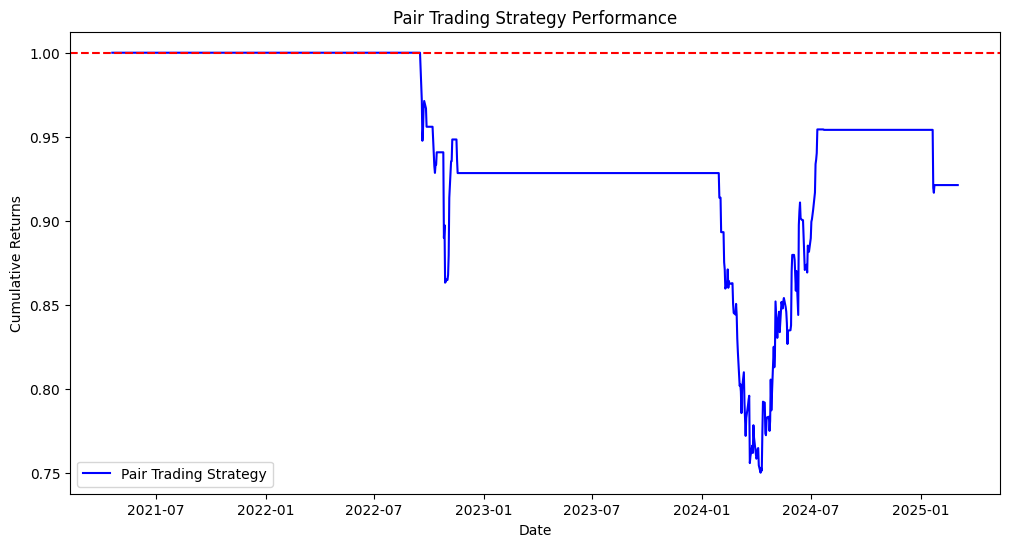

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(signals["cumulative_returns"], label="Pair Trading Strategy", color="blue")
plt.axhline(1, color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.title("Pair Trading Strategy Performance")
plt.show()


Step 8: Live Trading Execution in MT5

In [ ]:
def execute_trade(signal, symbol1, symbol2):
    """
    Executes trades in MetaTrader 5.
    If 'long', buys symbol1 & sells symbol2.
    If 'short', sells symbol1 & buys symbol2.
    If 'exit', closes all positions.
    """
    if signal == "long":
        mt5.order_send(
            mt5.ORDER_TYPE_BUY, symbol1, volume=1
        )
        mt5.order_send(
            mt5.ORDER_TYPE_SELL, symbol2, volume=1
        )
    elif signal == "short":
        mt5.order_send(
            mt5.ORDER_TYPE_SELL, symbol1, volume=1
        )
        mt5.order_send(
            mt5.ORDER_TYPE_BUY, symbol2, volume=1
        )
    elif signal == "exit":
        mt5.positions_close(symbol1)
        mt5.positions_close(symbol2)

# Execute trade based on last signal
latest_signal = signals.iloc[-1]

if latest_signal["long"]:
    execute_trade("long", "AAPL.NAS", "MSFT.NAS")
elif latest_signal["short"]:
    execute_trade("short", "AAPL.NAS", "MSFT.NAS")
elif latest_signal["exit"]:
    execute_trade("exit", "AAPL.NAS", "MSFT.NAS")
